<a href="https://colab.research.google.com/github/cluePrints/fastai-v3-notes/blob/master/fastai3_part2_05b_early_stopping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [0]:
def sorta_import(name):
  import urllib.request
  import os
  a = urllib.request.urlopen(f'https://raw.githubusercontent.com/fastai/fastai_docs/master/dev_course/dl2/exp/{name}.py')
  os.makedirs('exp', exist_ok=True)
  with open(f'exp/{name}.py', 'wb') as f:
    f.write(a.read())
  __import__(f'exp.{name}')

def load_modules_up_to(n_inclusive):
  for i in range(n_inclusive + 1):
    try:
      sorta_import(f'nb_0{i}')
    except:
      print(f"Problem importing {i}")
      raise

load_modules_up_to(5)
from exp.nb_05 import *

In [0]:
train_x,train_y,valid_x,valid_y = get_data()
train_ds,valid_ds = Dataset(train_x,train_y),Dataset(valid_x,valid_y)
n_hidden, batch_size = 50, 512
n_classes = train_y.max().item()+1
loss_func = F.cross_entropy

In [0]:
data = DataBunch(*get_dls(train_ds, valid_ds, batch_size), n_classes)

In [0]:
class Callback():
    _order=0
    def set_runner(self, run): self.run=run
    def __getattr__(self, k): return getattr(self.run, k)
    
    @property
    def name(self):
        name = re.sub(r'Callback$', '', self.__class__.__name__)
        return camel2snake(name or 'callback')
    
    def __call__(self, cb_name):
        f = getattr(self, cb_name, None)
        if f and f(): return True
        return False

class TrainEvalCallback(Callback):
    def begin_fit(self):
        self.run.n_epochs=0.
        self.run.n_iter=0
    
    def after_batch(self):
        if not self.in_train: return
        self.run.n_epochs += 1./self.iters
        self.run.n_iter   += 1
        
    def begin_epoch(self):
        self.run.n_epochs=self.epoch
        self.model.train()
        self.run.in_train=True

    def begin_validate(self):
        self.model.eval()
        self.run.in_train=False

class CancelTrainException(Exception): pass
class CancelEpochException(Exception): pass
class CancelBatchException(Exception): pass

In [0]:
# version from nb_04
class Runner():
    def __init__(self, cbs=None, cb_funcs=None):
        cbs = listify(cbs)
        for cbf in listify(cb_funcs):
            cb = cbf()
            setattr(self, cb.name, cb)
            cbs.append(cb)
        self.stop,self.cbs = False,[TrainEvalCallback()]+cbs

    @property
    def opt(self):       return self.learn.opt
    @property
    def model(self):     return self.learn.model
    @property
    def loss_func(self): return self.learn.loss_func
    @property
    def data(self):      return self.learn.data

    def one_batch(self, xb, yb):
        self.xb,self.yb = xb,yb
        if self('begin_batch'): return
        self.pred = self.model(self.xb)
        if self('after_pred'): return
        self.loss = self.loss_func(self.pred, self.yb)
        if self('after_loss') or not self.in_train: return
        self.loss.backward()
        if self('after_backward'): return
        self.opt.step()
        if self('after_step'): return
        self.opt.zero_grad()

    def all_batches(self, dl):
        self.iters = len(dl)
        for xb,yb in dl:
            if self.stop: break
            self.one_batch(xb, yb)
            self('after_batch')
        self.stop=False

    def fit(self, epochs, learn):
        self.epochs,self.learn,self.loss = epochs,learn,tensor(0.)

        try:
            for cb in self.cbs: cb.set_runner(self)
            if self('begin_fit'): return
            for epoch in range(epochs):
                self.epoch = epoch
                if not self('begin_epoch'): self.all_batches(self.data.train_dl)

                with torch.no_grad():
                    if not self('begin_validate'): self.all_batches(self.data.valid_dl)
                if self('after_epoch'): break

        finally:
            self('after_fit')
            self.learn = None

    def __call__(self, cb_name):
        for cb in sorted(self.cbs, key=lambda x: x._order):
            f = getattr(cb, cb_name, None)
            if f and f(): return True


In [0]:
learn = create_learner(get_model, loss_func, data)
import pdb

class RaiseExceptionCallback(Callback):
  def __init__(self, exception_class, limit=10):
    self.exception_class = exception_class
    self.limit = limit

  _order=1
  def after_step(self):
    print(self.n_iter)
    if self.n_iter>=self.limit:
      print("Raising an exception")
      raise self.exception_class()

run = Runner(cb_funcs=lambda: RaiseExceptionCallback(CancelTrainException, 2))

In [8]:
def test_exception_raised(tested_func, expected_class):
  try:
    tested_func()
    raise Exception(f"Expected {expected_class} to be thrown")
  except Exception as e:
    if not isinstance(e, expected_class):
      raise

    return e

test_exception_raised(lambda: run.fit(3, learn), CancelTrainException)

0
1
2
Raising an exception


__main__.CancelTrainException()

In [0]:
class Runner():
    def __init__(self, cbs=None, cb_funcs=None):
        cbs = listify(cbs)
        for cbf in listify(cb_funcs):
            cb = cbf()
            setattr(self, cb.name, cb)
            cbs.append(cb)
        self.stop,self.cbs = False,[TrainEvalCallback()]+cbs

    @property
    def opt(self):       return self.learn.opt
    @property
    def model(self):     return self.learn.model
    @property
    def loss_func(self): return self.learn.loss_func
    @property
    def data(self):      return self.learn.data

    def one_batch(self, xb, yb):
        self.xb,self.yb = xb,yb
        self('begin_batch')
        self.pred = self.model(self.xb)
        self('after_pred')
        self.loss = self.loss_func(self.pred, self.yb)
        if self('after_loss') or not self.in_train: return
        self.loss.backward()
        self('after_backward')
        self.opt.step()
        self('after_step')
        self.opt.zero_grad()

    def all_batches(self, dl):
        self.iters = len(dl)
        for xb,yb in dl:
            try:
              self.one_batch(xb, yb)
            except CancelBatchException:
              self('after_cancel_batch')
            finally:
              self('after_batch')
        self.stop=False

    def fit(self, epochs, learn):
        self.epochs,self.learn,self.loss = epochs,learn,tensor(0.)

        try:
            for cb in self.cbs: cb.set_runner(self)
            if self('begin_fit'): return
            for epoch in range(epochs):
              try:
                  self.epoch = epoch
                  if not self('begin_epoch'): self.all_batches(self.data.train_dl)

                  with torch.no_grad():
                      if not self('begin_validate'): self.all_batches(self.data.valid_dl)
              except CancelEpochException:
                  self('after_cancel_epoch')
              finally:
                  self('after_epoch')
        except CancelTrainException:
            self('after_cancel_train')
        finally:
            self('after_fit')
            self.learn = None

    def __call__(self, cb_name):
        for cb in sorted(self.cbs, key=lambda x: x._order):
            f = getattr(cb, cb_name, None)
            if f and f(): return True


In [10]:
run = Runner(cb_funcs=lambda: RaiseExceptionCallback(CancelTrainException, 0))
run.fit(3, learn)

0
Raising an exception


In [11]:
run = Runner(cb_funcs=lambda: RaiseExceptionCallback(CancelEpochException, 0))
run.fit(3, learn)

0
Raising an exception
1
Raising an exception
2
Raising an exception


In [0]:
import io
from contextlib import redirect_stdout

In [0]:
%%capture out
run = Runner(cb_funcs=lambda: RaiseExceptionCallback(CancelBatchException, -1))
run.fit(3, learn)

In [14]:
print('\n'.join(out.stdout.split('\n')[:7]))

0
Raising an exception
1
Raising an exception
2
Raising an exception
3


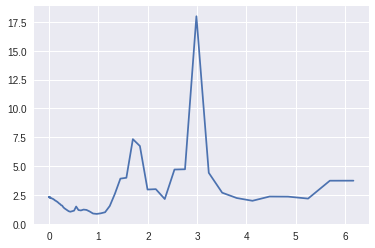

In [15]:
class Recorder(Callback):
    def begin_fit(self):
        self.lrs = [[] for _ in self.opt.param_groups]
        self.losses = []

    def after_batch(self):
        if not self.in_train: return
        for pg,lr in zip(self.opt.param_groups,self.lrs): lr.append(pg['lr'])
        self.losses.append(self.loss.detach().cpu())        

    def plot_lr  (self, pgid=-1): plt.plot(self.lrs[pgid])
    def plot_loss(self, skip_last=0): plt.plot(self.losses[:len(self.losses)-skip_last])
        
    def plot(self, skip_last=0, pgid=-1):
        losses = [o.item() for o in self.losses]
        lrs    = self.lrs[pgid]
        n = len(losses)-skip_last
        plt.xscale('log')
        plt.plot(lrs[:n], losses[:n])

class LrFinderCallback(Callback):
  def __init__(self, min_lr, max_lr, max_iterations = 100):
    self.min_lr = min_lr
    self.max_lr = max_lr
    self.max_iterations = max_iterations
    self.losses = []
    self.lrs_tried = []
    self.best_loss = float('Inf')

  def begin_batch(self):
    self._stop_when_tried_all()
    self._set_next_lr()
# Note to self: it's fun that it actually seem to work better when model state preserved between different LR's tried
#    self._load_model()
    
  def after_step(self):
    self._save_loss()
    self._stop_when_crappy_trend()
  
  def begin_fit(self):
    self._save_model()

  def after_fit(self):
    self._load_model()
    
  def plot_losses(self, skip_end=0):
    plt.plot(self.lrs_tried[:-skip_end], self.losses[:-skip_end])

  def _set_next_lr(self):
    lr_idx = len(self.losses)
    progress = lr_idx / self.max_iterations
    ratio = self.max_lr / self.min_lr
    lr_to_try = self.min_lr * ratio ** progress
    for group in self.opt.param_groups:
      group['lr'] = lr_to_try
    
  def _stop_when_tried_all(self):
    if (len(self.losses) >= self.max_iterations): raise CancelTrainException()

  def _stop_when_crappy_trend(self):
    if (len(self.losses) < 5):
      return

    avg_last_loss = sum(self.losses[-5:])/5
    if (self.best_loss*10 < avg_last_loss):
      raise CancelTrainException()

  def _save_loss(self):
    last_loss = self.run.loss.detach().item()
    self.lrs_tried.append(self.opt.param_groups[0]['lr'])
    self.losses.append(last_loss)
    self.best_loss = min(self.best_loss, last_loss)

  def _save_model(self): torch.save(self.run.model.state_dict(), 'tmp')
    
  def _load_model(self): self.run.model.load_state_dict(torch.load('tmp'))

learner = create_learner(get_model, loss_func, data)
finder = LrFinderCallback(1e-6, 10, 200)
run = Runner(cb_funcs=[lambda: finder, Recorder])
run.fit(3, learner)
finder.plot_losses(skip_end=5)

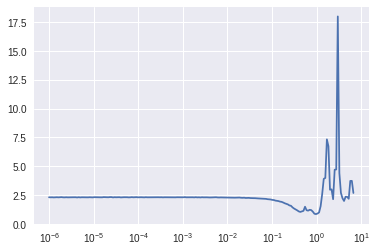

In [16]:
# Note to self: this looks nicer with log scale
run.recorder.plot(skip_last=5)

In [0]:
# CancelTrainException, CancelEpochException, CancelBatchException
# update runner
# lr_finder
# ---